# Music Genre Classification using FMA Dataset

In [1]:
# Data handling
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Audio processing
import librosa
import librosa.display
import audioread

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [7]:
# Define paths - adjust these to your local setup
FMA_PATH = 'fma_small'  # Update this path
METADATA_PATH = 'fma_metadata/tracks.csv'  # Update this path

In [4]:
def load_metadata(metadata_path):
    """
    Load FMA metadata and prepare genre labels
    """
    # Load with chunks to handle the complex structure of the CSV
    tracks = pd.read_csv(metadata_path, index_col=0, header=[0, 1])
    
    # Extract track IDs and genre information from metadata
    tracks_filtered = tracks.loc[tracks.index.isin(tracks.index)]
    
    # Extract genre information - focus on coarse genres
    genres = tracks_filtered[('track', 'genre_top')]
    
    # Create mapping from track ID to genre
    genre_mapping = genres.to_dict()
    
    # Get track IDs with valid genres
    valid_tracks = genres.dropna().index
    
    # Track IDs need to be converted to folder paths
    def track_id_to_path(track_id):
        """Convert track ID to folder path structure used in FMA"""
        tid_str = '{:06d}'.format(track_id)
        return os.path.join(FMA_PATH, tid_str[:3], tid_str + '.mp3')
    
    track_paths = {tid: track_id_to_path(tid) for tid in valid_tracks if os.path.exists(track_id_to_path(tid))}
    
    # Return track paths and their corresponding genres
    tracks_with_genres = {path: genre_mapping[tid] for tid, path in track_paths.items()}
    
    return tracks_with_genres

In [5]:
# Function to extract mel spectrogram features from audio
def extract_features(file_path, n_mfcc=40, n_fft=2048, hop_length=512, sr=22050, duration=30):
    """
    Extract MFCCs from an audio file for feature extraction
    """
    try:
        # Load audio file with specific duration
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        
        # Normalize MFCCs
        mfccs = (mfccs - np.mean(mfccs)) / np.std(mfccs)
        
        return mfccs
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to generate mel spectrograms for visualization
def generate_melspectrogram(file_path, sr=22050, duration=30):
    """
    Generate mel spectrogram for visualization
    """
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db
    except Exception as e:
        print(f"Error generating mel spectrogram for {file_path}: {e}")
        return None

In [6]:
# Custom Dataset for Audio Classification
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label

Loading metadata...
Total tracks with valid genres: 8000

Genre distribution:
Hip-Hop          1000
Pop              1000
Folk             1000
Experimental     1000
Rock             1000
International    1000
Electronic       1000
Instrumental     1000
Name: count, dtype: int64


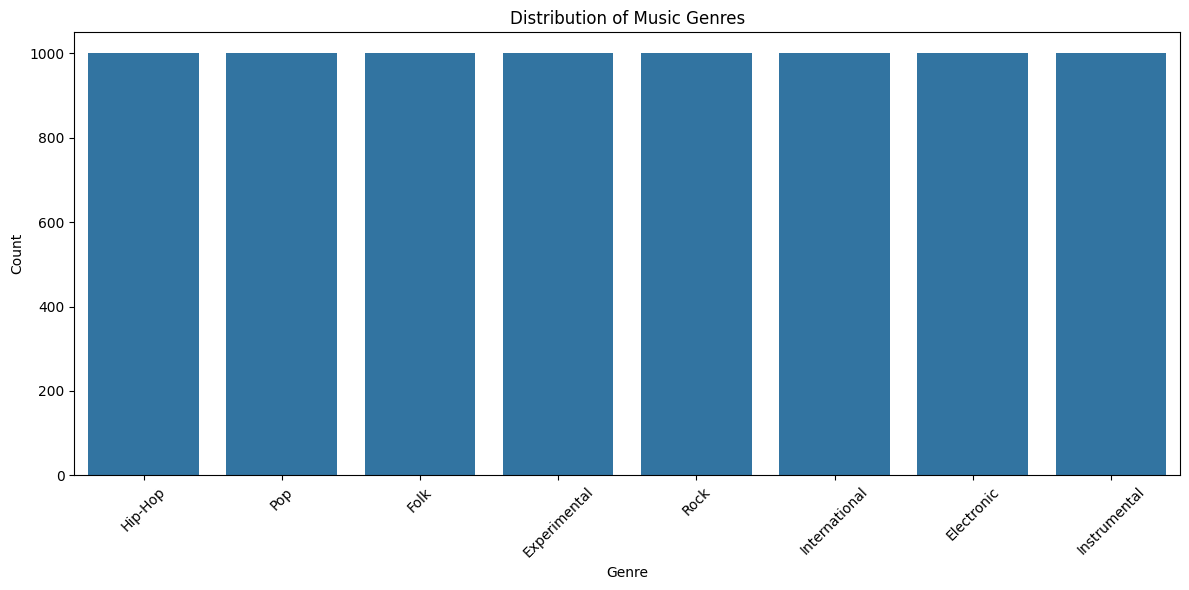

In [8]:
# Load metadata and prepare data
print("Loading metadata...")
tracks_with_genres = load_metadata(METADATA_PATH)

# Print information about dataset
print(f"Total tracks with valid genres: {len(tracks_with_genres)}")
genre_counts = pd.Series([g for g in tracks_with_genres.values()]).value_counts()
print("\nGenre distribution:")
print(genre_counts)

# Visualize genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Distribution of Music Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Prepare data for feature extraction
# Limit the number of samples per genre for balanced dataset (optional)
MAX_SAMPLES_PER_GENRE = 1000  # Adjust as needed

# Group tracks by genre
tracks_by_genre = {}
for path, genre in tracks_with_genres.items():
    if genre not in tracks_by_genre:
        tracks_by_genre[genre] = []
    tracks_by_genre[genre].append(path)

# Balance the dataset
balanced_tracks = []
balanced_genres = []
for genre, tracks in tracks_by_genre.items():
    track_subset = tracks[:MAX_SAMPLES_PER_GENRE]
    balanced_tracks.extend(track_subset)
    balanced_genres.extend([genre] * len(track_subset))

print(f"Total tracks after balancing: {len(balanced_tracks)}")

Total tracks after balancing: 8000


In [10]:
# Visualize some examples of mel spectrograms
def visualize_examples(tracks, genres, num_examples=3):
    """
    Visualize mel spectrograms for a few examples from each genre
    """
    # Get unique genres
    unique_genres = list(set(genres))
    
    # Create a figure with subplots
    fig, axes = plt.subplots(len(unique_genres), num_examples, figsize=(15, 3*len(unique_genres)))
    
    # Iterate through genres
    for i, genre in enumerate(unique_genres):
        # Find tracks of this genre
        genre_indices = [idx for idx, g in enumerate(genres) if g == genre]
        
        # Select random examples
        selected_indices = np.random.choice(genre_indices, min(num_examples, len(genre_indices)), replace=False)
        
        for j, idx in enumerate(selected_indices):
            mel_spec = generate_melspectrogram(tracks[idx])
            if mel_spec is not None:
                if len(unique_genres) > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[j]
                librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', sr=22050, ax=ax)
                ax.set_title(f"{genre}")
                ax.set_xlabel('')
                if j == 0:
                    ax.set_ylabel('Mel Bins')
                else:
                    ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


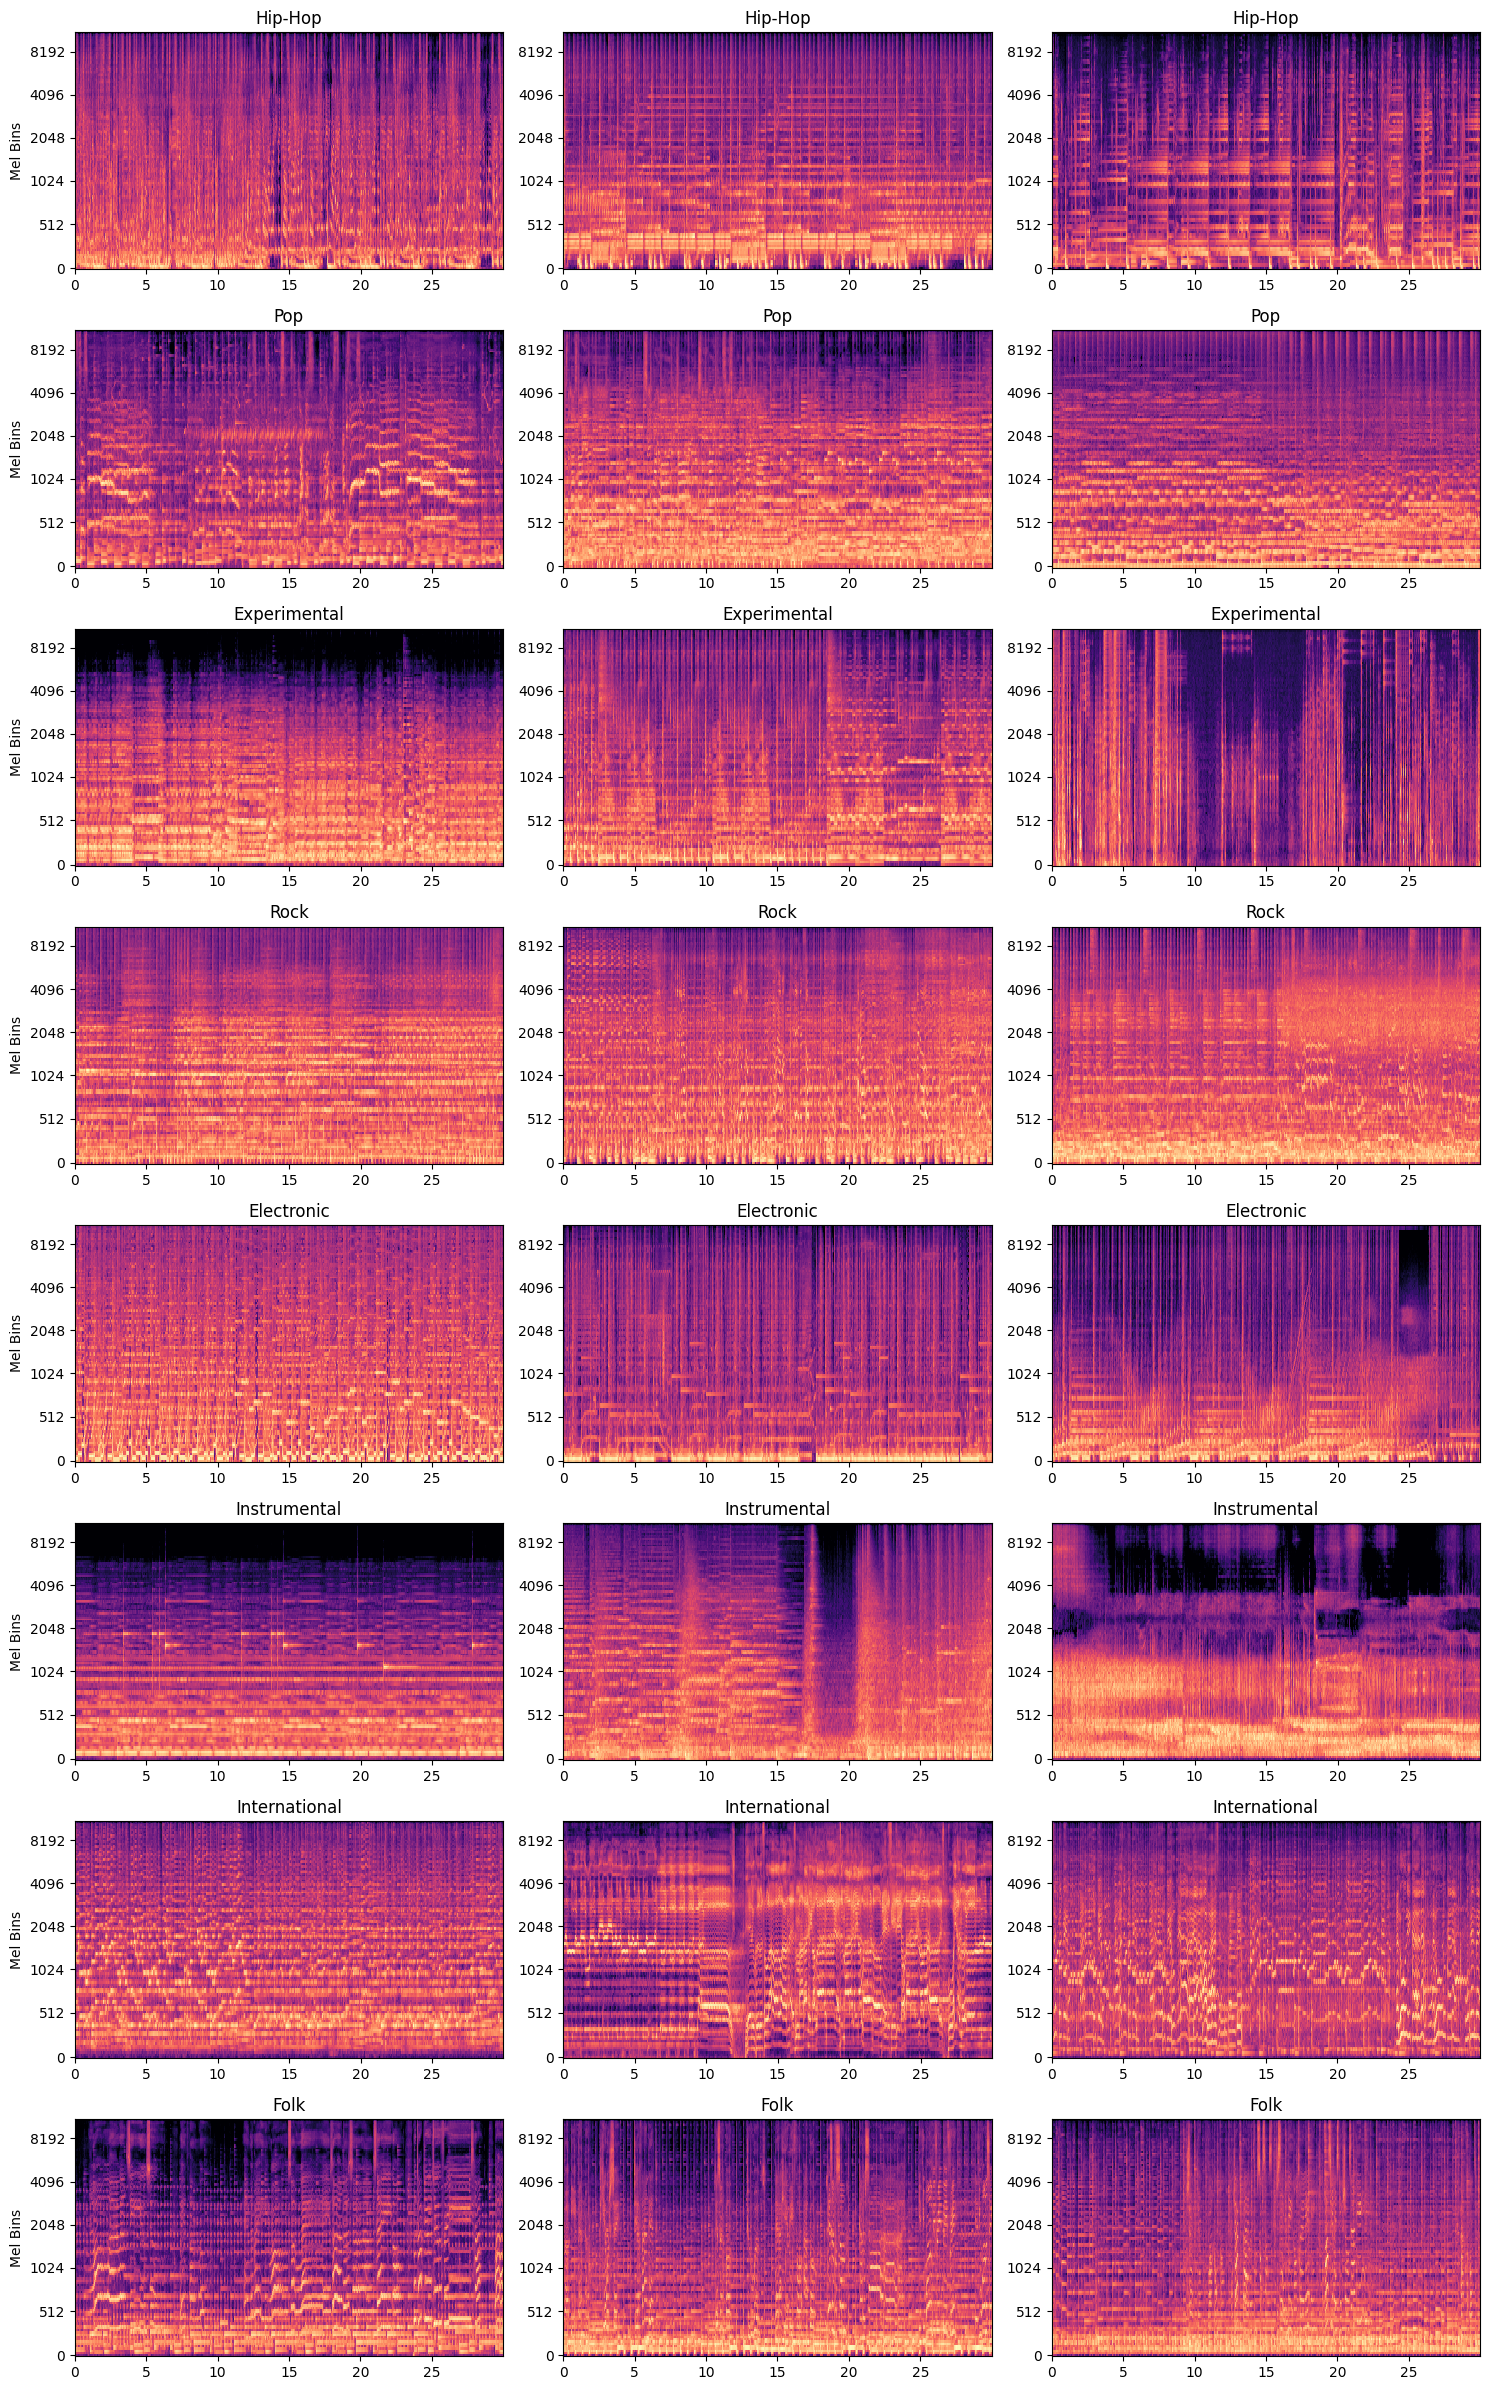

In [11]:
# Visualize examples
visualize_examples(balanced_tracks, balanced_genres)

In [23]:
def extract_features_torchaudio(file_path, n_mfcc=40, fixed_length=128):
    """
    Extract MFCCs using torchaudio with more robust handling of audio files
    """
    try:
        # Load audio with torchaudio
        waveform, sample_rate = torchaudio.load(file_path)
        
        # If stereo, convert to mono by averaging channels
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Resample if needed (most audio ML works with 16kHz or 22.05kHz)
        target_sample_rate = 22050
        if sample_rate != target_sample_rate:
            resampler = torchaudio.transforms.Resample(
                orig_freq=sample_rate, 
                new_freq=target_sample_rate
            )
            waveform = resampler(waveform)
            sample_rate = target_sample_rate
        
        # Create MFCC transform
        mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,
            melkwargs={
                'n_fft': 2048, 
                'hop_length': 512, 
                'n_mels': 128,
                'center': True,
                'norm': 'slaney',
                'mel_scale': 'htk'
            }
        )
        
        # Extract MFCCs
        mfccs = mfcc_transform(waveform)
        
        # Reshape to match the expected output format (n_mfcc, time)
        mfccs = mfccs.squeeze(0).numpy()
        
        # Handle length consistency
        if mfccs.shape[1] < fixed_length:
            # Pad if too short
            pad_width = fixed_length - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate if too long
            mfccs = mfccs[:, :fixed_length]
        
        # Normalize
        mfccs = (mfccs - np.mean(mfccs)) / (np.std(mfccs) + 1e-8)
        
        return mfccs
        
    except Exception as e:
        print(f"Error processing {file_path} with torchaudio: {e}")
        return None
    
# Feature extraction loop using torchaudio exclusively
print("Extracting features from audio files using torchaudio...")
X = []
y = []
fixed_length = 128

# Set a limit for debugging
MAX_FILES = 10000  # Adjust as needed

for i, (track_path, genre) in enumerate(tqdm(zip(balanced_tracks, balanced_genres), total=min(len(balanced_tracks), MAX_FILES))):
    if i >= MAX_FILES:
        break
        
    features = extract_features_torchaudio(track_path, fixed_length=fixed_length)
    if features is not None:
        X.append(features)
        y.append(genre)

# Verify we have some features
if len(X) == 0:
    raise ValueError("No features were successfully extracted. Check audio file formats and paths.")
else:
    print(f"Successfully extracted features from {len(X)} files using torchaudio")

# Convert lists to numpy arrays
X = np.array(X)
print(f"X shape: {X.shape}")

# Reshape for CNN input (add channel dimension)
X = X[..., np.newaxis]  # Shape: (n_samples, n_mfcc, fixed_length, 1)
print(f"X reshaped: {X.shape}")


# Encode genre labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"Genre classes: {label_encoder.classes_}")

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Define batch size
batch_size = 32

# Create datasets
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Extracting features from audio files using torchaudio...


  7%|▋         | 573/8000 [00:40<08:53, 13.92it/s]Note: Illegal Audio-MPEG-Header 0x00000000 at offset 33361.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 63168.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
  7%|▋         | 578/8000 [00:40<06:20, 19.52it/s

Error processing fma_small/098/098565.mp3 with torchaudio: Unspecified internal error.
Error processing fma_small/098/098567.mp3 with torchaudio: Unspecified internal error.
Error processing fma_small/098/098569.mp3 with torchaudio: Unspecified internal error.


 49%|████▉     | 3937/8000 [05:16<04:34, 14.80it/s]

Error processing fma_small/133/133297.mp3 with torchaudio: Error opening 'fma_small/133/133297.mp3': File does not exist or is not a regular file (possibly a pipe?).


 57%|█████▋    | 4590/8000 [06:10<04:28, 12.71it/s]

Error processing fma_small/108/108925.mp3 with torchaudio: Error opening 'fma_small/108/108925.mp3': File does not exist or is not a regular file (possibly a pipe?).


 82%|████████▏ | 6565/8000 [08:50<01:40, 14.27it/s]

Error processing fma_small/099/099134.mp3 with torchaudio: Error opening 'fma_small/099/099134.mp3': File does not exist or is not a regular file (possibly a pipe?).


100%|██████████| 8000/8000 [10:46<00:00, 12.38it/s]


Successfully extracted features from 7994 files using torchaudio
X shape: (7994, 40, 128)
X reshaped: (7994, 40, 128, 1)
Genre classes: ['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']
Training set: (6395, 40, 128, 1), Test set: (1599, 40, 128, 1)


In [31]:
# Define CNN model using PyTorch
class GenreClassifier(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(GenreClassifier, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.3)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.4)
        
        # Calculate the size of the flattened features
        # This depends on the input shape and the pooling operations
        self._to_linear = self._get_conv_output(input_shape)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def _get_conv_output(self, shape):
        # Dummy forward pass to calculate output dimensions
        with torch.no_grad():
            batch_size = 1
            input = torch.zeros(batch_size, *shape)
            output = self._forward_features(input)
            return int(np.prod(output.size()))
        
    def _forward_features(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

In [32]:
# Initialize model
input_shape = (1, X_train.shape[1], X_train.shape[2])  # (channels, height, width)
num_classes = len(label_encoder.classes_)
model = GenreClassifier(input_shape, num_classes).to(device)

# Print model summary
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

GenreClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=10240, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=

In [33]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

In [34]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(dataloader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # PyTorch expects channel first for CNNs
        inputs = inputs.permute(0, 3, 1, 2)  # (batch, height, width, channel) -> (batch, channel, height, width)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [35]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Validation"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # PyTorch expects channel first for CNNs
            inputs = inputs.permute(0, 3, 1, 2)  # (batch, height, width, channel) -> (batch, channel, height, width)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [36]:
num_epochs = 50
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

# Split training data into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# Early stopping parameters
patience = 10
counter = 0
best_val_loss = float('inf')

In [37]:
print("Starting training...")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # Save best model
            torch.save(model.state_dict(), 'best_genre_classifier.pth')
            print(f"Saved best model with validation accuracy: {val_acc:.4f}")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print("-" * 50)

print("Training completed!")

Starting training...
Epoch 1/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 36.58it/s]


Saved best model with validation accuracy: 0.3065
Train Loss: 1.7993, Train Acc: 0.3194
Val Loss: 1.9403, Val Acc: 0.3065
--------------------------------------------------
Epoch 2/50


Validation: 100%|██████████| 40/40 [-1:59:59<00:00, -31.45it/s]


Saved best model with validation accuracy: 0.3448
Train Loss: 1.6492, Train Acc: 0.3880
Val Loss: 1.8830, Val Acc: 0.3448
--------------------------------------------------
Epoch 3/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 39.22it/s]


Saved best model with validation accuracy: 0.3464
Train Loss: 1.5773, Train Acc: 0.4285
Val Loss: 1.7946, Val Acc: 0.3464
--------------------------------------------------
Epoch 4/50


Validation: 100%|██████████| 40/40 [00:00<00:00, 40.01it/s]


Saved best model with validation accuracy: 0.4418
Train Loss: 1.5254, Train Acc: 0.4482
Val Loss: 1.5881, Val Acc: 0.4418
--------------------------------------------------
Epoch 5/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 38.95it/s]


Train Loss: 1.4781, Train Acc: 0.4701
Val Loss: 1.6561, Val Acc: 0.4269
--------------------------------------------------
Epoch 6/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 37.55it/s]


Train Loss: 1.4279, Train Acc: 0.4937
Val Loss: 1.5983, Val Acc: 0.4480
--------------------------------------------------
Epoch 7/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 39.49it/s]


Train Loss: 1.3935, Train Acc: 0.5043
Val Loss: 1.5426, Val Acc: 0.4300
--------------------------------------------------
Epoch 8/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 38.27it/s]


Saved best model with validation accuracy: 0.4449
Train Loss: 1.3333, Train Acc: 0.5195
Val Loss: 1.5208, Val Acc: 0.4449
--------------------------------------------------
Epoch 9/50


Validation: 100%|██████████| 40/40 [00:00<00:00, 40.09it/s]


Saved best model with validation accuracy: 0.4535
Train Loss: 1.3003, Train Acc: 0.5375
Val Loss: 1.5115, Val Acc: 0.4535
--------------------------------------------------
Epoch 10/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 38.30it/s]


Train Loss: 1.2632, Train Acc: 0.5549
Val Loss: 1.5988, Val Acc: 0.4347
--------------------------------------------------
Epoch 11/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 38.94it/s]


Train Loss: 1.2159, Train Acc: 0.5715
Val Loss: 1.6076, Val Acc: 0.4308
--------------------------------------------------
Epoch 12/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 38.97it/s]


Train Loss: 1.1658, Train Acc: 0.5864
Val Loss: 1.5264, Val Acc: 0.4566
--------------------------------------------------
Epoch 13/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 39.66it/s]


Train Loss: 1.1258, Train Acc: 0.5952
Val Loss: 1.5740, Val Acc: 0.4629
--------------------------------------------------
Epoch 14/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 39.11it/s]


Train Loss: 1.0678, Train Acc: 0.6155
Val Loss: 1.6097, Val Acc: 0.4418
--------------------------------------------------
Epoch 15/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 37.53it/s]


Train Loss: 1.0366, Train Acc: 0.6343
Val Loss: 1.5941, Val Acc: 0.4582
--------------------------------------------------
Epoch 16/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 39.14it/s]


Train Loss: 0.9405, Train Acc: 0.6679
Val Loss: 1.5197, Val Acc: 0.4660
--------------------------------------------------
Epoch 17/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 39.52it/s]


Train Loss: 0.8934, Train Acc: 0.6869
Val Loss: 1.5757, Val Acc: 0.4707
--------------------------------------------------
Epoch 18/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 39.47it/s]


Train Loss: 0.8519, Train Acc: 0.7007
Val Loss: 1.6014, Val Acc: 0.4590
--------------------------------------------------
Epoch 19/50


Validation: 100%|██████████| 40/40 [00:01<00:00, 39.03it/s]

Early stopping at epoch 19
Training completed!


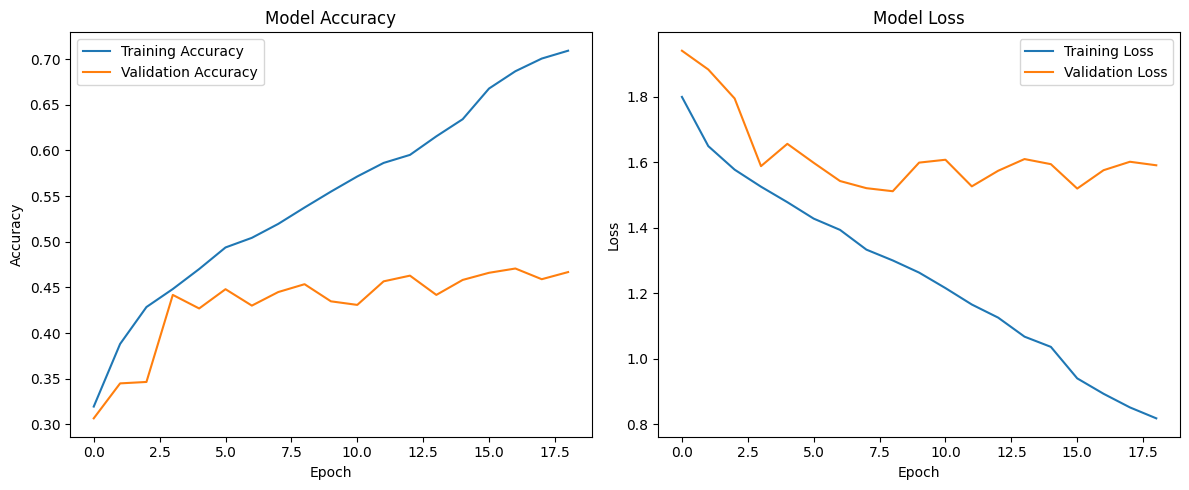

In [38]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_genre_classifier.pth'))
model.eval()

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Validation: 100%|██████████| 50/50 [00:01<00:00, 32.13it/s]

Test Loss: 1.5293, Test Accuracy: 0.4628


In [40]:
# Detailed evaluation
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # PyTorch expects channel first for CNNs
        inputs = inputs.permute(0, 3, 1, 2)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Print classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=label_encoder.classes_))


Classification Report:
               precision    recall  f1-score   support

   Electronic       0.60      0.17      0.26       200
 Experimental       0.38      0.52      0.43       200
         Folk       0.45      0.67      0.54       200
      Hip-Hop       0.52      0.68      0.59       199
 Instrumental       0.47      0.46      0.46       200
International       0.52      0.54      0.53       200
          Pop       0.24      0.11      0.15       200
         Rock       0.52      0.56      0.54       200

     accuracy                           0.46      1599
    macro avg       0.46      0.46      0.44      1599
 weighted avg       0.46      0.46      0.44      1599



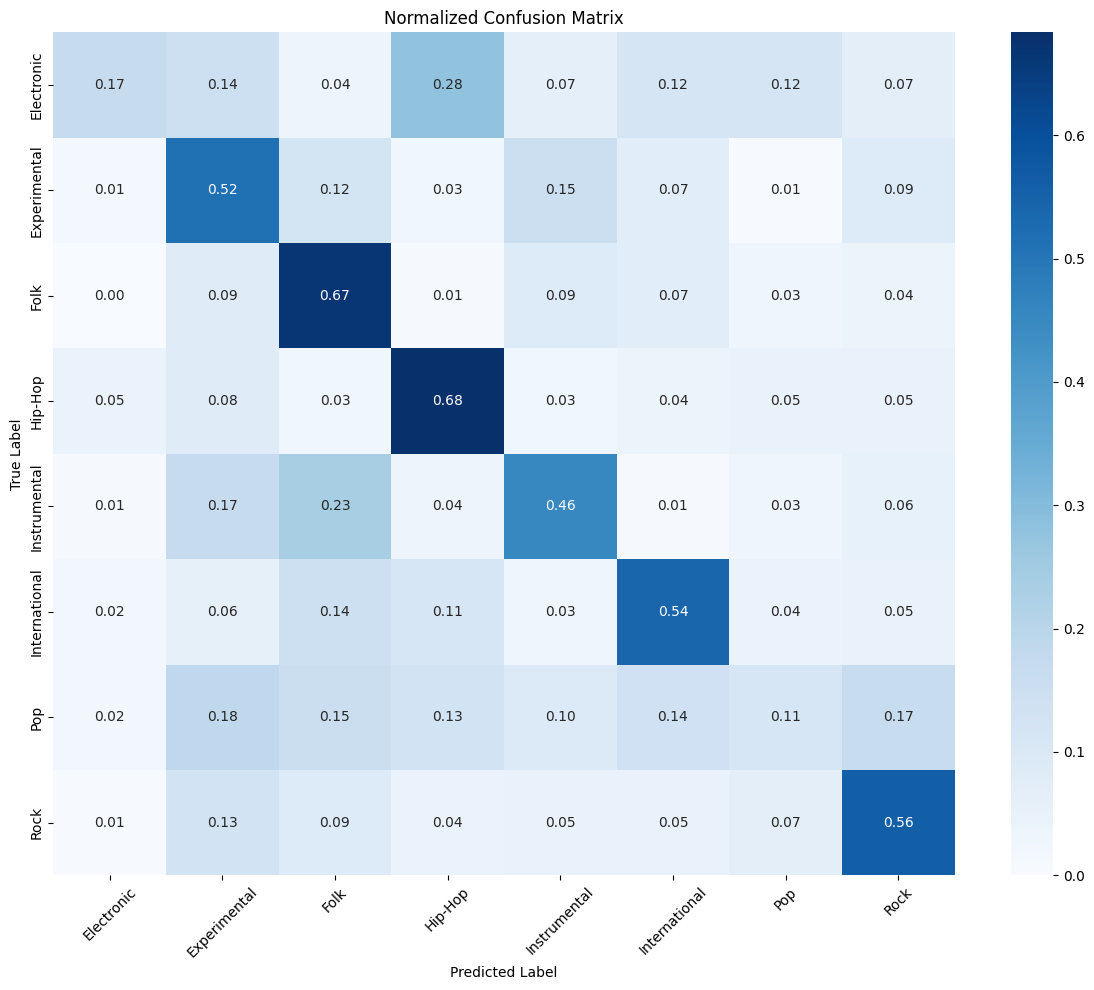

In [41]:
# Plot confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(all_targets, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Function to predict genre of a new audio file
def predict_genre(file_path, model, label_encoder, device):
    """
    Predict the genre of a new audio file using torchaudio
    """
    model.eval()
    
    # Extract features using torchaudio
    features = extract_features_torchaudio(file_path)
    if features is None:
        return "Error processing audio file", 0.0
    
    # Add channel dimension and convert to tensor
    features = features[np.newaxis, ..., np.newaxis]  # Shape: (1, n_mfcc, time_steps, 1)
    features_tensor = torch.tensor(features, dtype=torch.float32).to(device)
    
    # PyTorch expects channel first for CNNs
    features_tensor = features_tensor.permute(0, 3, 1, 2)  # (batch, height, width, channel) -> (batch, channel, height, width)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(features_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_idx].item()
    
    predicted_genre = label_encoder.classes_[predicted_idx]
    
    return predicted_genre, confidence

In [ ]:
# Example of how to save and load the trained model
# Save model (already done during training)
# torch.save(model.state_dict(), 'genre_classifier_model.pth')

# Load model
# model = GenreClassifier(input_shape, num_classes).to(device)
# model.load_state_dict(torch.load('genre_classifier_model.pth'))
# model.eval()

# Example prediction
# Let's select a random test file for prediction
# Example prediction visualization
if len(X_test) > 0:
    test_idx = np.random.randint(0, len(X_test))
    test_file = balanced_tracks[test_idx]
    true_genre = balanced_genres[test_idx]
    
    # Predict genre
    predicted_genre, confidence = predict_genre(test_file, model, label_encoder, device)
    
    print(f"\nExample Prediction:")
    print(f"File: {test_file}")
    print(f"True Genre: {true_genre}")
    print(f"Predicted Genre: {predicted_genre}")
    print(f"Confidence: {confidence:.4f}")
    
    # Visualize the audio file
    plt.figure(figsize=(12, 4))
    
    # Load with torchaudio
    waveform, sample_rate = torchaudio.load(test_file)
    if waveform.shape[0] > 1:  # Convert stereo to mono if needed
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Plot waveform
    plt.subplot(1, 2, 1)
    plt.plot(waveform[0].numpy())
    plt.title(f"Waveform - {true_genre}")
    
    # Plot mel spectrogram using torchaudio
    plt.subplot(1, 2, 2)
    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    )(waveform)
    mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
    plt.imshow(mel_spec_db[0].numpy(), aspect='auto', origin='lower')
    plt.title(f"Predicted: {predicted_genre} ({confidence:.2f})")
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()